In [2]:
import numpy as np
import pandas as pd
import glob

# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import math
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

from f_sr_calculation import *

work_dir=Path("/scratch/fransjevanoors/global_sr")
# work_dir=Path("/mnt/u/LSM root zone/global_sr")
#work_dir=Path('/tudelft.net/staff-umbrella/LSM root zone/global_sr')
data_dir=Path(f'{work_dir}/data')
out_dir = Path(f"{work_dir}/output")

In [212]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)

In [152]:
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
snow_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')
snow_dir = f'{work_dir}/output/snow/timeseries_gswp'
irri_ids = np.loadtxt(f'{work_dir}/output/irrigation/catchment_irri_area_5percent.txt',dtype=str)

catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]

# check which catchments are missing
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.8ia/sd/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-11] # remove .year extension
    el_id_list.append(f)
dif = list(set(catch_list) - set(el_id_list))
print(len(dif))
catch_list = dif
# catch_list

2591


In [175]:
catch_id = 'id_0000009'
catch_id = 'in_0000096'
catch_id = 'us_0006742'
catch_id = 'in_0000005'
catch_id = 'fr_0000889'

In [176]:
"""
run calculation of storage deficits (1)

catch_id:    str, catchment id
pep_dir:     str, dir, directory of P and Ep timeseries
q_dir:       str, dir, directory of Q timeseries
out_dir:     str, dir, output directory

returns: out:sd timeseries, stores out dataframe (Sd calculation) as csv
"""

if catch_id in snow_id_list:
    s = 1 # snow is yes
    f_pep = glob.glob(f'{snow_dir}/{catch_id}*.csv')

else:
    s = 0 # snow is no
    # get P Ep and Q files for catch id
    f_pep = glob.glob(f'{pep_dir}/{catch_id}*.csv')

cc = pd.read_csv(f'{work_dir}/output/catchment_characteristics/gswp-p_gleam-ep_gswp-t/{catch_id}.csv',index_col=0)
ir_area = cc.ir_mean.values

# read q df
f_q = glob.glob(f'{q_dir}/{catch_id}*.csv')

# read files as dataframes
q_ts = pd.read_csv(f_q[0],index_col=0)
q_ts.index = pd.to_datetime(q_ts.index)
pep_ts = pd.read_csv(f_pep[0],index_col=0)
pep_ts.index = pd.to_datetime(pep_ts.index)

if (s==1): #snow
    # convert to monthly dataframes
    df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep','ps','pm','pl'])
    df_monthly[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']].groupby(pd.Grouper(freq="M")).sum()

    # calculate start hydroyear -> month after on average the wettest month
    df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
    df_monthly_mean['liq'] = df_monthly_mean['pm'] + df_monthly_mean['pl']
    wettest_month = (df_monthly_mean['liq']-df_monthly_mean['ep']).idxmax()
    hydro_year_start_month = wettest_month+1
    if hydro_year_start_month==13:
        hydro_year_start_month=1

else: # no snow
    # convert to monthly dataframes
    df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep'])
    df_monthly[['p','ep']] = pep_ts[['p','ep']].groupby(pd.Grouper(freq="M")).sum()

    # calculate start hydroyear -> month after on average the wettest month
    df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
    wettest_month = (df_monthly_mean['p']-df_monthly_mean['ep']).idxmax()
    hydro_year_start_month = wettest_month+1
    if hydro_year_start_month==13:
        hydro_year_start_month=1

# find the start and end date for the sr calculation based on P, Ep, Q timeseries and hydroyear
p_ep_start_year = pep_ts.index.year[0]
q_start_year = int(q_ts.index[0].year)
p_ep_end_year = pep_ts.index.year[-1]
q_end_year = int(q_ts.index[-1].year)

# test if timeseries have overlap -> if not don't continue the sd calculation
if q_start_year>p_ep_end_year:
    a=1
elif p_ep_start_year>q_end_year:
    a=1
else:
    a=0
    start_year = max(q_start_year,p_ep_start_year)
    end_year = min(q_end_year,p_ep_end_year)
    start_date = datetime(start_year,hydro_year_start_month,1)
    end_date = datetime(end_year,hydro_year_start_month,1)
    end_date = end_date - timedelta(days=1)

    #calculate mean Q for startdate enddate timeseries
    q_mean = q_ts.loc[start_date:end_date,'Q'].mean()

    if (s==1): # snow
        # prepare input dataframe for sd calculation
        sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','ps','pm','pl','date_start','date_end'])
        sd_input[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']]
        sd_input[['date_start','date_end']] = start_date, end_date
        si_0 = 0 #initial interception storage
        si_max = 2.5 #maximum interception storage

    else: # no snow
        # prepare input dataframe for sd calculation
        sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','date_start','date_end'])
        sd_input[['p','ep']] = pep_ts[['p','ep']]
        sd_input[['date_start','date_end']] = start_date, end_date
        si_0 = 0 #initial interception storage
        si_max = 2.5 #maximum interception storage

    # run sd calculation
    b = sd_initial(sd_input, si_0, si_max, q_mean,s)[0] #b==0: closing wb, b==1: non-closing wb > no sd calculation
    if b==0:      
        # save output dataframe from sd calculation
        out = sd_initial(sd_input, si_0, si_max, q_mean,s)[1]

#         # if catch_id in irri_id_list:
#         # if ir_area>0.01:
#         if ir_area>0:
#             irri = irrigation_sd(out,catch_id,work_dir)
#             out = irri[0] 
#             se_out = irri[1]
#             f = irri[2]
#             se_out.to_csv(f'{out_dir}/irri/f0.8ia/se/{catch_id}_f0.8ia.csv')
#             # se_out.to_csv(f'{out_dir}/irri/fiwu2/se/{catch_id}_fiwu2.csv')
#             # se_out.to_csv(f'{out_dir}/irri/se/{catch_id}_f{f}ia.csv')

#             out.to_csv(f'{out_dir}/irri/f0.8ia/sd/{catch_id}_f0.8ia.csv')
#             # out.to_csv(f'{out_dir}/{catch_id}.csv')
#             # out.to_csv(f'{out_dir}/irri/fiwu2/sd/{catch_id}_fiwu2.csv')
#             # out.to_csv(f'{out_dir}/irri/sd/{catch_id}_f{f}ia.csv')
#         else: 
#             # out.to_csv(f'{out_dir}/irri/fiwu2/sd/{catch_id}_fiwu2.csv')
#             out.to_csv(f'{out_dir}/irri/f0.8ia/sd/{catch_id}_f0.8ia.csv')


/home/fvanoorschot/miniconda3/envs/sr_env/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/fvanoorschot/miniconda3/envs/sr_env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [177]:
out

,p,ep,date_start,date_end,Si_1,Pe,Si_2,Ei,Si_3,Et,Sd,se
1981-01-01,0.983632,0.153504,1981-01-01,1989-12-31,0.983632,0.000000,0.983632,0.153504,0.830128,0.118376,-0.118376,0.000000
1981-01-02,0.989082,0.087681,1981-01-01,1989-12-31,1.819210,0.000000,1.819210,0.087681,1.731529,0.067616,-0.185992,0.000000
1981-01-03,7.548127,0.321105,1981-01-01,1989-12-31,9.279656,6.779656,2.500000,0.321105,2.178895,0.247623,0.000000,6.532034
1981-01-04,17.910660,0.530780,1981-01-01,1989-12-31,20.089555,17.589555,2.500000,0.530780,1.969220,0.409315,0.000000,17.180240
1981-01-05,0.658637,0.163906,1981-01-01,1989-12-31,2.627858,0.127858,2.500000,0.163906,2.336094,0.126398,0.000000,0.001460
...,...,...,...,...,...,...,...,...,...,...,...,...
1989-12-27,0.000000,0.170667,1981-01-01,1989-12-31,2.023999,0.000000,2.023999,0.170667,1.853332,0.131612,-70.753279,0.000000
1989-12-28,0.000000,0.147517,1981-01-01,1989-12-31,1.853332,0.000000,1.853332,0.147517,1.705815,0.113759,-70.867038,0.000000
1989-12-29,0.000000,0.127029,1981-01-01,1989-12-31,1.705815,0.000000,1.705815,0.127029,1.578787,0.097959,-70.964997,0.000000
1989-12-30,0.000000,0.165467,1981-01-01,1989-12-31,1.578787,0.000000,1.578787,0.165467,1.413320,0.127601,-71.092599,0.000000


Text(0, 0.5, 'Sd (mm)')

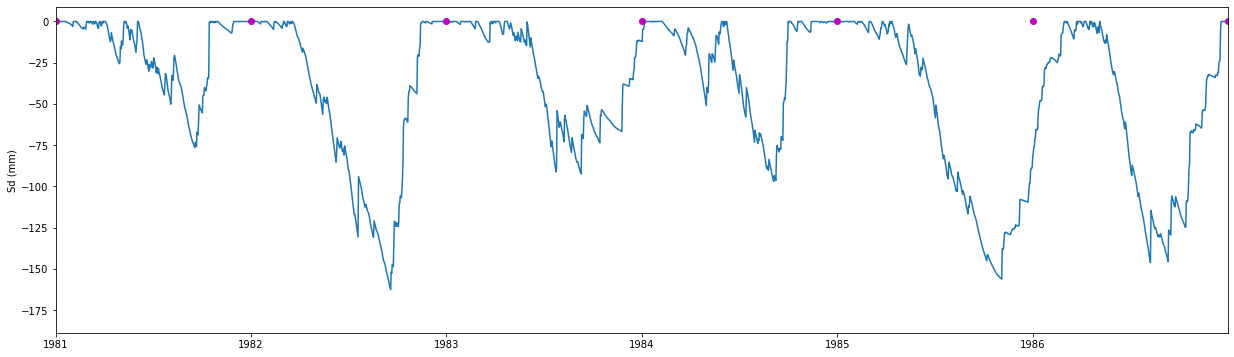

In [178]:
# plot Sd timeseries and the start dates of each hydrological year used for Sr calculation
a = []
for i in range(len(out.index.year.unique())):
    a.append(datetime(year=out.index.year.unique()[i],month=out.index.month[0],day=out.index.day[0]))

fig = plt.figure(figsize=(21,6))
ax = fig.add_subplot(111)
ax.plot(out.index,out.Sd)
ax.plot(a,np.zeros(len(a)),'mo')
ax.set_xlim(out.index[0],out.index[6*365])
ax.set_ylabel('Sd (mm)')

In [193]:
s = out
df = out

split_dates = [] # dates of annual maximum deficit
start_date = df.index[0]
split_dates.append(start_date) # add start date to split_dates

se_l = [] # accumulated Se available
se_used = [] # used Se
ldd_l = [] # last day of deficit
lde_l = [] # first day of deficit
days_l = [] # amount of deficit days
f_ar = [] # f values used

s2 = s #make new dataframe, copy of s which is output of initial sd calculation
s2['p_total'] = np.zeros(len(s2)) # add zeros column of total p = pe+irri
s2['p_irri'] = np.zeros(len(s2)) # add zeros column of irri
s2['sd2']=s.Sd # set sd2 column intially equal to sd
s2['se2']=s.se # set se2 column intially equal to se
s2['se_cum'] = np.zeros(len(s2)) # set zeros column for cumulative se

iwu = pd.read_csv(f'{work_dir}/output/irrigation/processed2/monthly_mean/{catch_id}.csv',index_col=0) # read iwu data
iwu_mean = iwu.mean().values[0]*365 # annual mean IWU
ir2 = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia.csv',index_col=0) #read ia data
ir_area = ir2.loc[catch_id].hi # irrigated area fraction

ldd_l.append(s.index[0]) # add first day of timeseries to ldd_l list

years=len(np.unique(s.index.year)) #count years
# years = 5
for i in range(years): # loop over years
    ss = s2.iloc[i*365:(i*365)+365] #select 1 year from s2 dataframe
    min_date = ss[ss.Sd==ss.Sd.min()].index.values[0] #select date where Sd minimizes
    split_dates.append(min_date) #append min date to split_dates list
    sp = s2.loc[split_dates[i]:split_dates[i+1]] # split timeseries from min-date year i until year i+1

    # find start + end dates of deficit and surplus periods
    if (i==0): # for first year
        sss = ss.loc[:min_date] # select timeseries until minimum sd date
        if (len(sss.se[sss.se>0])>0): 
            lde = sss.se[sss.se>0].index[-1] # find last day of se>0 before minimum deficit (=start day deficit)
        else:
            lde = sss.index[0]   

        ldd_l.append(lde) # append to list

        sss = ss.loc[min_date:] # select timeseries from minimum sd date to end
        if (len(sss.Sd[sss.Sd==0])>0):
            ldd = sss[sss.Sd==0].index[0] # find first day of zero deficit after minimum deficit (=end day deficit)
        else:
            ldd = sss.Sd.index[-1]
        ldd_l.append(ldd) # append to list
    else: # for other years than i=0
        sss = ss.loc[:min_date] # select timeseries until minimum sd date
        if (len(sss.se[sss.se>0])>0):
            lde = sss.se[sss.se>0].index[-1] # find last day of se>0 before minimum deficit (=start day deficit)
        else:
            lde = sss.index[0]   
        ldd_l.append(lde)
        
        # lde = ldd_l[i]
        sss = ss.loc[min_date:]  # select timeseries from minimum sd date to end
        if (len(sss.Sd[sss.Sd==0])>0):
            ldd = sss[sss.Sd==0].index[0] # find first day of zero deficit after minimum deficit (=end day deficit)
        else:
            ldd = sss.Sd.index[-1]
        # lde_l.append(lde)
        ldd_l.append(ldd)
    
    # accumulate Se for accumulation period
    dfse2 = pd.DataFrame(index=ss.index,columns=['se','se_cum']) # make new dataframe for year i
    dfse2['se'] = ss['se2'] # set se to se2 from ss dataset
    dfse2['se_cum'] = np.zeros(len(ss)) # make zeros se_cum column

    if(i==0): # for first year
        if (len(dd)>0): # all years except last year
            cum = dfse2['se'].loc[ldd_l[0]:ldd_l[1]].cumsum() # cumsum of se from start timeseries to start deficit
            dfse2.se_cum.loc[ldd_l[0]:ldd_l[1]] = cum # add cumsum to dataframe

            dfse2.se_cum.loc[ldd_l[1]:ldd_l[2]] = np.zeros(len(dfse2.se_cum.loc[ldd_l[1]:ldd_l[2]])) # se_cum for deficit period is zero

            cum = dfse2['se'].loc[ldd_l[2]:].cumsum() # cumsum of se from end deficit to end timeseries
            dfse2.se_cum.loc[ldd_l[2]:] = cum # add cumsum to dataframe       

            s2.se_cum.iloc[i*365:(i*365)+365] = dfse2.se_cum # add cumsum to s2 dataframe
    else: # other years than i=0
        if (len(dd)>0): # all years except last year
            s_index = dfse2.index[0]-timedelta(days=1) # get last day of previous year
            ss_s = s2.se_cum.loc[s_index] # get se_cum value for last day of previous year
            cum = dfse2['se'].loc[:ldd_l[2*i+1]].cumsum() + ss_s # cumsum of se from start year to start deficit + se_cum value from last day of previous year
            dfse2.se_cum.loc[:ldd_l[2*i+1]] = cum # add to dataframe

            dfse2.se_cum.loc[ldd_l[2*i+1]:ldd_l[2*i+2]] = np.zeros(len(dfse2.se_cum.loc[ldd_l[2*i+1]:ldd_l[2*i+2]])) # se_cum for deficit period is zero

            cum = dfse2['se'].loc[ldd_l[2*i+2]:].cumsum() # cumsum of se from end deficit to end timeseries
            dfse2.se_cum.loc[ldd_l[2*i+2]:] = cum # add cumsum to dataframe         

            s2.se_cum.iloc[i*365:(i*365)+365] = dfse2.se_cum # add cumsum to s2 dataframe
    
    # get length of irrigation timeseries
    if (i==0): # first year
        dd = ss.loc[ldd_l[i+1]+timedelta(days=1):ldd_l[i+2]] # set irrigation period from start deficit until end deficit
    else: # other years than i=0
        dd = ss.loc[ldd_l[2*i+1]+timedelta(days=1):ldd_l[2*i+2]] # select from start of deficit until end of deficit period
    days = len(dd) # length of deficit period = length of irrigation period
    days_l.append(days) # append deficit days to days_l list
    
    # DEFINE f-VARIABLE
    if (days>0):
        if (i==0):
            se_sum = s2.se_cum.loc[ldd_l[i+1]-timedelta(days=1)] # total se is value of se_cum last day before deficit period
        else:
            se_sum = s2.se_cum.loc[ldd_l[2*i+1]-timedelta(days=1)] # total se is value of se_cum last day before deficit period    
    
    # f based on fixed factor and irrigated area fraction
    f = 0.2
    f2 = min(f*ir_area, 1) 
    f_ar.append(f2) 
    if (days>0):
        irri = f2 * se_sum/days # calculate the irrigation fraction per day, equally distributed over the deficit period
        se_used.append(f2*se_sum)
    else:
        irri=0
        se_used.append(0)
    se_l.append(se_sum) # append se_sum to se_l list

    # # f based on IWU directly
    # if (se_sum>0):
    #     f = iwu_mean/se_sum
    # else: 
    #     f=0
    # if (f>1):
    #     f=1
    # f2=f
    # f_ar.append(f2)       
    # if (days>0):
    #     irri = f2 * se_sum/days # calculate the irrigation rates per day, equally distributed over the deficit period
    #     se_used.append(f2*se_sum) # used se is f2*se_sum
    # else:
    #     irri=0
    #     se_used.append(0)
    # se_l.append(se_sum) # append se_sum to se_l list
    
    # CALCULATE IRRIGATION
    p_irri = dd['Pe'] + irri # precipitation+irrigation for deficit period
    dd['irri'] = irri
    
    dfp2 = pd.DataFrame(index=ss.index, columns=['p_irri']) # make new p-irri dataframe for year i
    dfp2.p_irri = p_irri
    dfp2 = dfp2.fillna(-1) # if no irrigation, set to nan
    dfp2.p_irri.loc[dfp2[dfp2.p_irri<0].index] = ss.Pe.loc[dfp2[dfp2.p_irri<0].p_irri.index] # set nan values (set to -1) in dfp2 (no irrigation) to original p values
    ss['p_irri'] = dd['irri'] # only irrigation
    ss['p_irri'] = ss['p_irri'].fillna(0)
    ss['p_total'] = dfp2['p_irri'] # sum of Pe and irrigation
    s2.p_total.iloc[i*365:(i*365)+365] = ss['p_total'] #update p_total = irri+pe in s2
    s2.p_irri.iloc[i*365:(i*365)+365] = ss['p_irri'] #update p_total = irri+pe in s2
       
    #update sd and se in full timeseries from year -> end
    for l in range(i*365,len(s2)):
        if (i==0)&(l==0):
            s2['sd2'].iloc[l]=0
        else:
            s2['sd2'].iloc[l] = min(0,s2['sd2'].iloc[l-1]+s2['p_total'][l]-s2['Et'][l])
        if (s2['sd2'].iloc[l]==0):
            s2['se2'].iloc[l] = s2.p_total[l]-s2.Et[l]

# make irrigation dataframe
df_se = pd.DataFrame(index=range(len(se_used)), columns=['start_date_irri','end_date_irri','se','f','se_used','iwu_mean','days_irri'])
df_se['se'] = se_l
df_se['se_used'] = se_used
df_se['f'] = f_ar
df_se['start_date_irri'] = ldd_l[1::2] #odd values
df_se['end_date_irri'] = ldd_l[0::2][1:]
df_se['days_irri'] = days_l
df_se['iwu_mean'] = [iwu_mean] * len(df_se.index)

/tmp/ipykernel_175/3371933398.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2['p_total'] = np.zeros(len(s2)) # add zeros column of total p = pe+irri
/tmp/ipykernel_175/3371933398.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s2['p_irri'] = np.zeros(len(s2)) # add zeros column of irri
/tmp/ipykernel_175/3371933398.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [194]:
df_se

,start_date_irri,end_date_irri,se,f,se_used,iwu_mean,days_irri
0,1981-06-04,1981-10-17,193.586673,0.061669,11.938242,78.19021,135
1,1982-03-20,1982-11-17,272.030904,0.061669,16.775798,78.19021,242
2,1983-04-25,1983-12-31,283.066674,0.061669,17.456359,78.19021,250
3,1984-06-05,1984-10-01,127.505181,0.061669,7.863081,78.19021,118
4,1985-04-13,1985-12-30,269.413670,0.061669,16.614396,78.19021,261
5,1986-05-06,1986-12-19,74.877982,0.061669,4.617629,78.19021,227
6,1987-04-05,1987-10-06,127.947374,0.061669,7.890351,78.19021,184
7,1988-07-06,1988-12-22,352.098388,0.061669,21.713457,78.19021,169
8,1989-04-26,1989-12-29,100.892320,0.061669,6.221900,78.19021,247


IndexError: index 3650 is out of bounds for axis 0 with size 3287

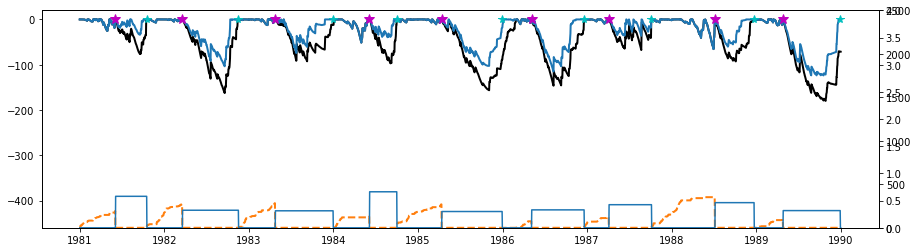

In [192]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax3 = ax.twinx()
# sd_fopt['pi'] = sd_fopt['p_irri']-sd_fopt['Pe']
ax3.plot(s2.index,s2.p_irri)
# ax2.plot(se_c_f0.index,se_c_f0)
# ax2.plot(se_c_fiwu.index,se_c_fiwu,color='tab:blue',linewidth=2,linestyle='--')
ax2.plot(s2.index,s2.se_cum,color='tab:orange',linewidth=2,linestyle='--')
ax.plot(s2.index, s2.Sd,color='k',linewidth=2)#,label='$S_{\mathrm{r,NI}}$='+str(int(sr_df.loc[c].sr_2_f0))+' mm')
ax.plot(s2.index, s2.sd2,color='tab:blue',linewidth=2)#, label='$S_{\mathrm{r,IWU}}$='+str(int(sr_df.loc[c].sr_2_fiwu))+' mm')
# ax.plot(sd_fopt.index, sd_fopt.sd2,color='tab:orange',linewidth=2)
# ax.plot(df_se.start_date_se,np.zeros(len(df_se)),'mo',markersize=10,label='start date se')
# ax.plot(df_se.end_date_se,np.zeros(len(df_se)),'co',markersize=5, label='end date se')
ax.plot(df_se.start_date_irri,np.zeros(len(df_se)),'m*',markersize=10, label='start date irri')
ax.plot(df_se.end_date_irri,np.zeros(len(df_se)),'c*',markersize=8, label='end date irri')
# ax.set_ylabel('Sd (mm)')
# ax.set_yticks([0,-100,-200])
# ax2.set_yticks([0,1000,2000,3000])
ax.set_ylim(-460,20)
ax3.set_ylim(0,4)
ax2.set_ylim(0,2500)
# ax2.set_ylim(0,3000)
# ax.set_ylabel('Sd (mm)', size=14)
# ax2.set_ylabel('Ss (mm)', size=14)
# ax.tick_params(axis='both', labelsize=14)
# ax2.tick_params(axis='y', labelsize=14)
# align_yaxis(ax, 0, ax2, 0)
# adjust_yaxis(ax,0,0)
ax.set_xlim(s2.index[0],s2.index[10*365])
ax.legend(ncol=2,fontsize=14,loc='lower left')

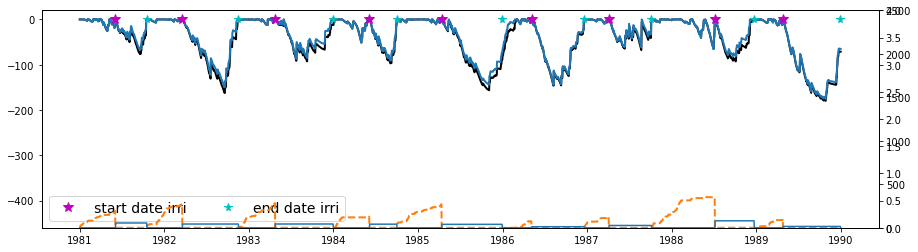

In [195]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax3 = ax.twinx()
# sd_fopt['pi'] = sd_fopt['p_irri']-sd_fopt['Pe']
ax3.plot(s2.index,s2.p_irri)
# ax2.plot(se_c_f0.index,se_c_f0)
# ax2.plot(se_c_fiwu.index,se_c_fiwu,color='tab:blue',linewidth=2,linestyle='--')
ax2.plot(s2.index,s2.se_cum,color='tab:orange',linewidth=2,linestyle='--')
ax.plot(s2.index, s2.Sd,color='k',linewidth=2)#,label='$S_{\mathrm{r,NI}}$='+str(int(sr_df.loc[c].sr_2_f0))+' mm')
ax.plot(s2.index, s2.sd2,color='tab:blue',linewidth=2)#, label='$S_{\mathrm{r,IWU}}$='+str(int(sr_df.loc[c].sr_2_fiwu))+' mm')
# ax.plot(sd_fopt.index, sd_fopt.sd2,color='tab:orange',linewidth=2)
# ax.plot(df_se.start_date_se,np.zeros(len(df_se)),'mo',markersize=10,label='start date se')
# ax.plot(df_se.end_date_se,np.zeros(len(df_se)),'co',markersize=5, label='end date se')
ax.plot(df_se.start_date_irri,np.zeros(len(df_se)),'m*',markersize=10, label='start date irri')
ax.plot(df_se.end_date_irri,np.zeros(len(df_se)),'c*',markersize=8, label='end date irri')
# ax.set_ylabel('Sd (mm)')
# ax.set_yticks([0,-100,-200])
# ax2.set_yticks([0,1000,2000,3000])
ax.set_ylim(-460,20)
ax3.set_ylim(0,4)
ax2.set_ylim(0,2500)
# ax2.set_ylim(0,3000)
# ax.set_ylabel('Sd (mm)', size=14)
# ax2.set_ylabel('Ss (mm)', size=14)
# ax.tick_params(axis='both', labelsize=14)
# ax2.tick_params(axis='y', labelsize=14)
# align_yaxis(ax, 0, ax2, 0)
# adjust_yaxis(ax,0,0)
# ax.set_xlim(s2.index[0],s2.index[10*365])
ax.legend(ncol=2,fontsize=14,loc='lower left')

In [215]:
## 2
def run_sd_calculation(catch_id, pep_dir, q_dir, out_dir,snow_id_list,snow_dir,work_dir):
    """
    run calculation of storage deficits (1)
    
    catch_id:    str, catchment id
    pep_dir:     str, dir, directory of P and Ep timeseries
    q_dir:       str, dir, directory of Q timeseries
    out_dir:     str, dir, output directory
    
    returns: out:sd timeseries, stores out dataframe (Sd calculation) as csv
    """
    
    if catch_id in snow_id_list:
        s = 1 # snow is yes
        f_pep = glob.glob(f'{snow_dir}/{catch_id}*.csv')

    else:
        s = 0 # snow is no
        # get P Ep and Q files for catch id
        f_pep = glob.glob(f'{pep_dir}/{catch_id}*.csv')
        
    cc = pd.read_csv(f'{work_dir}/output/catchment_characteristics/gswp-p_gleam-ep_gswp-t/{catch_id}.csv',index_col=0)
    ir_area = cc.ir_mean.values

    # read q df
    f_q = glob.glob(f'{q_dir}/{catch_id}*.csv')

    # read files as dataframes
    q_ts = pd.read_csv(f_q[0],index_col=0)
    q_ts.index = pd.to_datetime(q_ts.index)
    pep_ts = pd.read_csv(f_pep[0],index_col=0)
    pep_ts.index = pd.to_datetime(pep_ts.index)

    if (s==1): #snow
        # convert to monthly dataframes
        df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep','ps','pm','pl'])
        df_monthly[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']].groupby(pd.Grouper(freq="M")).sum()

        # calculate start hydroyear -> month after on average the wettest month
        df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
        df_monthly_mean['liq'] = df_monthly_mean['pm'] + df_monthly_mean['pl']
        wettest_month = (df_monthly_mean['liq']-df_monthly_mean['ep']).idxmax()
        hydro_year_start_month = wettest_month+1
        if hydro_year_start_month==13:
            hydro_year_start_month=1

    else: # no snow
        # convert to monthly dataframes
        df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep'])
        df_monthly[['p','ep']] = pep_ts[['p','ep']].groupby(pd.Grouper(freq="M")).sum()

        # calculate start hydroyear -> month after on average the wettest month
        df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
        wettest_month = (df_monthly_mean['p']-df_monthly_mean['ep']).idxmax()
        hydro_year_start_month = wettest_month+1
        if hydro_year_start_month==13:
            hydro_year_start_month=1

    # find the start and end date for the sr calculation based on P, Ep, Q timeseries and hydroyear
    p_ep_start_year = pep_ts.index.year[0]
    q_start_year = int(q_ts.index[0].year)
    p_ep_end_year = pep_ts.index.year[-1]
    q_end_year = int(q_ts.index[-1].year)

    # test if timeseries have overlap -> if not don't continue the sd calculation
    if q_start_year>p_ep_end_year:
        a=1
    elif p_ep_start_year>q_end_year:
        a=1
    else:
        a=0
        start_year = max(q_start_year,p_ep_start_year)
        end_year = min(q_end_year,p_ep_end_year)
        start_date = datetime(start_year,hydro_year_start_month,1)
        end_date = datetime(end_year,hydro_year_start_month,1)
        end_date = end_date - timedelta(days=1)

        #calculate mean Q for startdate enddate timeseries
        q_mean = q_ts.loc[start_date:end_date,'Q'].mean()

        if (s==1): # snow
            # prepare input dataframe for sd calculation
            sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','ps','pm','pl','date_start','date_end'])
            sd_input[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']]
            sd_input[['date_start','date_end']] = start_date, end_date
            si_0 = 0 #initial interception storage
            si_max = 2.5 #maximum interception storage

        else: # no snow
            # prepare input dataframe for sd calculation
            sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','date_start','date_end'])
            sd_input[['p','ep']] = pep_ts[['p','ep']]
            sd_input[['date_start','date_end']] = start_date, end_date
            si_0 = 0 #initial interception storage
            si_max = 2.5 #maximum interception storage

        # run sd calculation
        b = sd_initial(sd_input, si_0, si_max, q_mean,s)[0] #b==0: closing wb, b==1: non-closing wb > no sd calculation
        if b==0:      
            # save output dataframe from sd calculation
            out = sd_initial(sd_input, si_0, si_max, q_mean,s)[1]
            
            # if catch_id in irri_id_list:
            # if ir_area>0.01:
            if ir_area>0:
                irri = irrigation_sd(out,catch_id,work_dir)
                out = irri[0] 
                se_out = irri[1]
                f = irri[2]
                # se_out.to_csv(f'{out_dir}/irri/f0.8ia/se/{catch_id}_f0.8ia.csv')
                # se_out.to_csv(f'{out_dir}/irri/fiwu2/se/{catch_id}_fiwu2.csv')
                # se_out.to_csv(f'{out_dir}/irri/se/{catch_id}_f{f}ia.csv')
            
                # out.to_csv(f'{out_dir}/irri/f0.8ia/sd/{catch_id}_f0.8ia.csv')
                # out.to_csv(f'{out_dir}/{catch_id}.csv')
                # out.to_csv(f'{out_dir}/irri/fiwu2/sd/{catch_id}_fiwu2.csv')
                # out.to_csv(f'{out_dir}/irri/sd/{catch_id}_f{f}ia.csv')
            # else: 
                # out.to_csv(f'{out_dir}/irri/fiwu2/sd/{catch_id}_fiwu2.csv')
                # out.to_csv(f'{out_dir}/irri/f0.8ia/sd/{catch_id}_f0.8ia.csv')

            return out

In [216]:
def irrigation_sd(df,catch_id,work_dir):
    split_dates = [] # dates of annual maximum deficit
    start_date = df.index[0]
    split_dates.append(start_date) # add start date to split_dates

    se_l = [] # accumulated Se available
    se_used = [] # used Se
    ldd_l = [] # last day of deficit
    lde_l = [] # first day of deficit
    days_l = [] # amount of deficit days
    f_ar = [] # f values used

    s2 = s #make new dataframe, copy of s which is output of initial sd calculation
    s2['p_total'] = np.zeros(len(s2)) # add zeros column of total p = pe+irri
    s2['p_irri'] = np.zeros(len(s2)) # add zeros column of irri
    s2['sd2']=s.Sd # set sd2 column intially equal to sd
    s2['se2']=s.se # set se2 column intially equal to se
    s2['se_cum'] = np.zeros(len(s2)) # set zeros column for cumulative se

    iwu = pd.read_csv(f'{work_dir}/output/irrigation/processed2/monthly_mean/{catch_id}.csv',index_col=0) # read iwu data
    iwu_mean = iwu.mean().values[0]*365 # annual mean IWU
    ir2 = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia.csv',index_col=0) #read ia data
    ir_area = ir2.loc[catch_id].hi # irrigated area fraction

    ldd_l.append(s.index[0]) # add first day of timeseries to ldd_l list

    years=len(np.unique(s.index.year)) #count years
    # years = 5
    for i in range(years): # loop over years
        ss = s2.iloc[i*365:(i*365)+365] #select 1 year from s2 dataframe
        min_date = ss[ss.Sd==ss.Sd.min()].index.values[0] #select date where Sd minimizes
        split_dates.append(min_date) #append min date to split_dates list
        sp = s2.loc[split_dates[i]:split_dates[i+1]] # split timeseries from min-date year i until year i+1

        # find start + end dates of deficit and surplus periods
        if (i==0): # for first year
            sss = ss.loc[:min_date] # select timeseries until minimum sd date
            if (len(sss.se[sss.se>0])>0): 
                lde = sss.se[sss.se>0].index[-1] # find last day of se>0 before minimum deficit (=start day deficit)
            else:
                lde = sss.index[0]   

            ldd_l.append(lde) # append to list

            sss = ss.loc[min_date:] # select timeseries from minimum sd date to end
            if (len(sss.Sd[sss.Sd==0])>0):
                ldd = sss[sss.Sd==0].index[0] # find first day of zero deficit after minimum deficit (=end day deficit)
            else:
                ldd = sss.Sd.index[-1]
            ldd_l.append(ldd) # append to list
        else: # for other years than i=0
            sss = ss.loc[:min_date] # select timeseries until minimum sd date
            if (len(sss.se[sss.se>0])>0):
                lde = sss.se[sss.se>0].index[-1] # find last day of se>0 before minimum deficit (=start day deficit)
            else:
                lde = sss.index[0]   
            ldd_l.append(lde)

            # lde = ldd_l[i]
            sss = ss.loc[min_date:]  # select timeseries from minimum sd date to end
            if (len(sss.Sd[sss.Sd==0])>0):
                ldd = sss[sss.Sd==0].index[0] # find first day of zero deficit after minimum deficit (=end day deficit)
            else:
                ldd = sss.Sd.index[-1]
            # lde_l.append(lde)
            ldd_l.append(ldd)
        
        # get length of irrigation timeseries
        if (i==0): # first year
            dd = ss.loc[ldd_l[i+1]+timedelta(days=1):ldd_l[i+2]] # set irrigation period from start deficit until end deficit
        else: # other years than i=0
            dd = ss.loc[ldd_l[2*i+1]+timedelta(days=1):ldd_l[2*i+2]] # select from start of deficit until end of deficit period
        days = len(dd) # length of deficit period = length of irrigation period
        days_l.append(days) # append deficit days to days_l list

        # accumulate Se for accumulation period
        dfse2 = pd.DataFrame(index=ss.index,columns=['se','se_cum']) # make new dataframe for year i
        dfse2['se'] = ss['se2'] # set se to se2 from ss dataset
        dfse2['se_cum'] = np.zeros(len(ss)) # make zeros se_cum column

        if(i==0): # for first year
            if (len(dd)>0): # all years except last year
                cum = dfse2['se'].loc[ldd_l[0]:ldd_l[1]].cumsum() # cumsum of se from start timeseries to start deficit
                dfse2.se_cum.loc[ldd_l[0]:ldd_l[1]] = cum # add cumsum to dataframe

                dfse2.se_cum.loc[ldd_l[1]:ldd_l[2]] = np.zeros(len(dfse2.se_cum.loc[ldd_l[1]:ldd_l[2]])) # se_cum for deficit period is zero

                cum = dfse2['se'].loc[ldd_l[2]:].cumsum() # cumsum of se from end deficit to end timeseries
                dfse2.se_cum.loc[ldd_l[2]:] = cum # add cumsum to dataframe       

                s2.se_cum.iloc[i*365:(i*365)+365] = dfse2.se_cum # add cumsum to s2 dataframe
        else: # other years than i=0
            if (len(dd)>0): # all years except last year
                s_index = dfse2.index[0]-timedelta(days=1) # get last day of previous year
                ss_s = s2.se_cum.loc[s_index] # get se_cum value for last day of previous year
                cum = dfse2['se'].loc[:ldd_l[2*i+1]].cumsum() + ss_s # cumsum of se from start year to start deficit + se_cum value from last day of previous year
                dfse2.se_cum.loc[:ldd_l[2*i+1]] = cum # add to dataframe

                dfse2.se_cum.loc[ldd_l[2*i+1]:ldd_l[2*i+2]] = np.zeros(len(dfse2.se_cum.loc[ldd_l[2*i+1]:ldd_l[2*i+2]])) # se_cum for deficit period is zero

                cum = dfse2['se'].loc[ldd_l[2*i+2]:].cumsum() # cumsum of se from end deficit to end timeseries
                dfse2.se_cum.loc[ldd_l[2*i+2]:] = cum # add cumsum to dataframe         

                s2.se_cum.iloc[i*365:(i*365)+365] = dfse2.se_cum # add cumsum to s2 dataframe

        # DEFINE f-VARIABLE
        if (days>0):
            if (i==0):
                se_sum = s2.se_cum.loc[ldd_l[i+1]-timedelta(days=1)] # total se is value of se_cum last day before deficit period
            else:
                se_sum = s2.se_cum.loc[ldd_l[2*i+1]-timedelta(days=1)] # total se is value of se_cum last day before deficit period    

        # f based on fixed factor and irrigated area fraction
        f = 0.2
        f2 = min(f*ir_area, 1) 
        f_ar.append(f2) 
        if (days>0):
            irri = f2 * se_sum/days # calculate the irrigation fraction per day, equally distributed over the deficit period
            se_used.append(f2*se_sum)
        else:
            irri=0
            se_used.append(0)
        se_l.append(se_sum) # append se_sum to se_l list

        # # f based on IWU directly
        # if (se_sum>0):
        #     f = iwu_mean/se_sum
        # else: 
        #     f=0
        # if (f>1):
        #     f=1
        # f2=f
        # f_ar.append(f2)       
        # if (days>0):
        #     irri = f2 * se_sum/days # calculate the irrigation rates per day, equally distributed over the deficit period
        #     se_used.append(f2*se_sum) # used se is f2*se_sum
        # else:
        #     irri=0
        #     se_used.append(0)
        # se_l.append(se_sum) # append se_sum to se_l list

        # CALCULATE IRRIGATION
        p_irri = dd['Pe'] + irri # precipitation+irrigation for deficit period
        dd['irri'] = irri

        dfp2 = pd.DataFrame(index=ss.index, columns=['p_irri']) # make new p-irri dataframe for year i
        dfp2.p_irri = p_irri
        dfp2 = dfp2.fillna(-1) # if no irrigation, set to nan
        dfp2.p_irri.loc[dfp2[dfp2.p_irri<0].index] = ss.Pe.loc[dfp2[dfp2.p_irri<0].p_irri.index] # set nan values (set to -1) in dfp2 (no irrigation) to original p values
        ss['p_irri'] = dd['irri'] # only irrigation
        ss['p_irri'] = ss['p_irri'].fillna(0)
        ss['p_total'] = dfp2['p_irri'] # sum of Pe and irrigation
        s2.p_total.iloc[i*365:(i*365)+365] = ss['p_total'] #update p_total = irri+pe in s2
        s2.p_irri.iloc[i*365:(i*365)+365] = ss['p_irri'] #update p_total = irri+pe in s2

        #update sd and se in full timeseries from year -> end
        for l in range(i*365,len(s2)):
            if (i==0)&(l==0):
                s2['sd2'].iloc[l]=0
            else:
                s2['sd2'].iloc[l] = min(0,s2['sd2'].iloc[l-1]+s2['p_total'][l]-s2['Et'][l])
            if (s2['sd2'].iloc[l]==0):
                s2['se2'].iloc[l] = s2.p_total[l]-s2.Et[l]

    # make irrigation dataframe
    df_se = pd.DataFrame(index=range(len(se_used)), columns=['start_date_irri','end_date_irri','se','f','se_used','iwu_mean','days_irri'])
    df_se['se'] = se_l
    df_se['se_used'] = se_used
    df_se['f'] = f_ar
    df_se['start_date_irri'] = ldd_l[1::2] #odd values
    df_se['end_date_irri'] = ldd_l[0::2][1:]
    df_se['days_irri'] = days_l
    df_se['iwu_mean'] = [iwu_mean] * len(df_se.index)
    
    return(s2, df_se, f)

In [217]:
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
snow_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')
snow_dir = f'{work_dir}/output/snow/timeseries_gswp'
irri_ids = np.loadtxt(f'{work_dir}/output/irrigation/catchment_irri_area_5percent.txt',dtype=str)

catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]

# check which catchments are missing
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.8ia/sd/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-11] # remove .year extension
    el_id_list.append(f)
dif = list(set(catch_list) - set(el_id_list))
print(len(dif))
catch_list = dif


2591


In [218]:
catch_id = 'id_0000009'
# catch_id = 'in_0000096'
# catch_id = 'us_0006742'
# catch_id = 'in_0000005'
# catch_id = 'fr_0000889'

In [219]:
out = run_sd_calculation(catch_id, pep_dir, q_dir, out_dir,snow_id_list,snow_dir,work_dir)

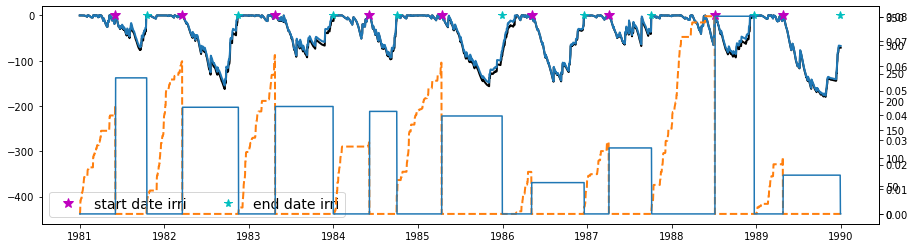

In [220]:
s2=out

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.plot(s2.index,s2.p_irri)
ax2.plot(s2.index,s2.se_cum,color='tab:orange',linewidth=2,linestyle='--')
ax.plot(s2.index, s2.Sd,color='k',linewidth=2)#,label='$S_{\mathrm{r,NI}}$='+str(int(sr_df.loc[c].sr_2_f0))+' mm')
ax.plot(s2.index, s2.sd2,color='tab:blue',linewidth=2)#, label='$S_{\mathrm{r,IWU}}$='+str(int(sr_df.loc[c].sr_2_fiwu))+' mm')
ax.plot(df_se.start_date_irri,np.zeros(len(df_se)),'m*',markersize=10, label='start date irri')
ax.plot(df_se.end_date_irri,np.zeros(len(df_se)),'c*',markersize=8, label='end date irri')
# ax.set_ylabel('Sd (mm)')
# ax.set_yticks([0,-100,-200])
# ax2.set_yticks([0,1000,2000,3000])
ax.set_ylim(-460,20)
# ax3.set_ylim(0,4)
# ax2.set_ylim(0,2500)
# ax2.set_ylim(0,3000)
# ax.set_ylabel('Sd (mm)', size=14)
# ax2.set_ylabel('Ss (mm)', size=14)
# ax.tick_params(axis='both', labelsize=14)
# ax2.tick_params(axis='y', labelsize=14)
# align_yaxis(ax, 0, ax2, 0)
# adjust_yaxis(ax,0,0)
# ax.set_xlim(s2.index[0],s2.index[10*365])
ax.legend(ncol=2,fontsize=14,loc='lower left')